## Import Modules

In [4]:
from numpy.random import seed
seed(888)

import tensorflow as tf
tf.random.set_seed(404)

In [5]:
import os
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

# Loading Dataset

In [6]:
def load_csv_from_zip(zip_path: str, filename: str, header=None, as_array: bool = True) -> pd.DataFrame:
    """
    Load a CSV file directly from a ZIP archive.

    Parameters
    ----------
    zip_path : str
        Path to the ZIP archive.
    filename : str
        Name of the CSV file inside the ZIP archive.
    header : int, list of int, or None, default None
        Row(s) to use as the column names. Use None to keep all rows as data.
    as_array : bool, default True
        If True, return as a NumPy array. If False, return as a DataFrame.

    Returns
    -------
    np.ndarray or pd.DataFrame
        Data in array or DataFrame format.
    """
    with zipfile.ZipFile(zip_path) as z:
        with z.open(filename) as f:
            df = pd.read_csv(f, header=header)
    return df.values if as_array else df

ZIP_PATH = "data/MNIST.zip"

x_train_all = load_csv_from_zip(ZIP_PATH, "digit_xtrain.csv")
x_test = load_csv_from_zip(ZIP_PATH, "digit_xtest.csv")
y_train_all = load_csv_from_zip(ZIP_PATH, "digit_ytrain.csv")
y_test = load_csv_from_zip(ZIP_PATH, "digit_ytest.csv")

## EDA

x_train shape: (60000, 784)
y_train shape: (60000, 1)
x_test shape: (10000, 784)
y_test shape: (10000, 1)


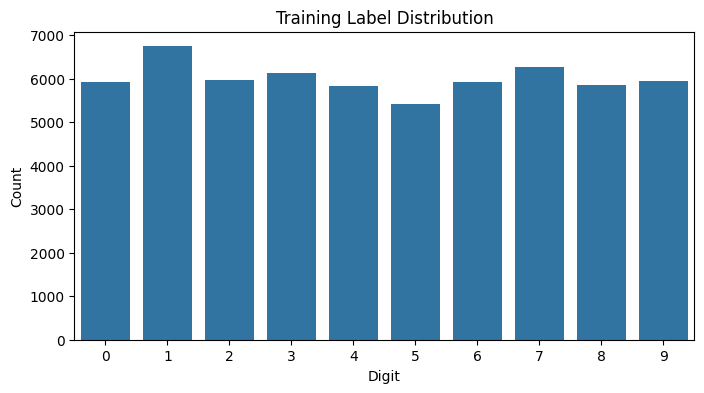

Missing values in x_train: 0
Missing values in y_train: 0
Missing values in x_test: 0
Missing values in y_test: 0
Pixel range in x_train: 0 to 255
Pixel range in x_test: 0 to 255


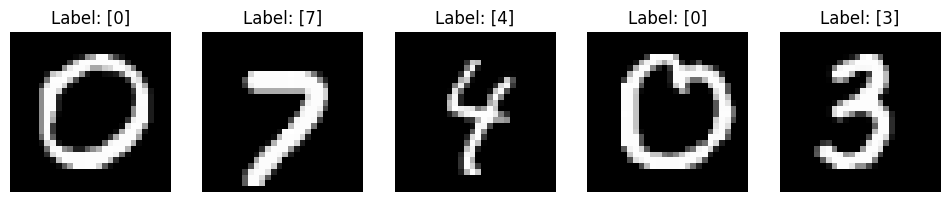

Train mean pixel value: 33.318421449829934
Train std pixel value: 78.56748998339742
Test mean pixel value: 33.791224489795916
Test std pixel value: 79.1724632222863


In [7]:
def eda_mnist(x_train, y_train, x_test, y_test, sample_size=5):
    # 1. Check shapes
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

    # 2. Check label distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y_train.flatten())
    plt.title("Training Label Distribution")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()

    # 3. Check missing values
    print("Missing values in x_train:", np.isnan(x_train).sum())
    print("Missing values in y_train:", np.isnan(y_train).sum())
    print("Missing values in x_test:", np.isnan(x_test).sum())
    print("Missing values in y_test:", np.isnan(y_test).sum())

    # 4. Check pixel value ranges
    print("Pixel range in x_train:", x_train.min(), "to", x_train.max())
    print("Pixel range in x_test:", x_test.min(), "to", x_test.max())

    # 5. Show random samples
    plt.figure(figsize=(12, 3))
    indices = np.random.choice(len(x_train), sample_size, replace=False)
    for i, idx in enumerate(indices):
        img = x_train[idx].reshape(28, 28)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Label: {y_train[idx]}")
    plt.show()

    # 6. Basic statistics
    print("Train mean pixel value:", np.mean(x_train))
    print("Train std pixel value:", np.std(x_train))
    print("Test mean pixel value:", np.mean(x_test))
    print("Test std pixel value:", np.std(x_test))

eda_mnist(x_train_all, y_train_all, x_test, y_test)

## Data Pre-processing

### Re-scale

In [8]:
# Re-scale data between 0 - 1
x_train_all, x_test = x_train_all/255.0 , x_test / 255.0

### Convert target values to one-hot encoding

In [9]:
NUM_CLASSES = 10

y_train_all = np.eye(NUM_CLASSES)[y_train_all.ravel()]
y_test = np.eye(NUM_CLASSES)[y_test.ravel()]

### Create Validation set from training data

In [10]:
VALIDATION_SIZE = 10000

x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]

## Setup Tensorflow Graph

Epoch 00 | Train Loss 0.3305 Acc 0.8998 | Val Loss 0.1514 Acc 0.9561
Epoch 01 | Train Loss 0.1276 Acc 0.9622 | Val Loss 0.1007 Acc 0.9684
Epoch 02 | Train Loss 0.0871 Acc 0.9739 | Val Loss 0.0864 Acc 0.9736
Epoch 03 | Train Loss 0.0638 Acc 0.9797 | Val Loss 0.0748 Acc 0.9781
Epoch 04 | Train Loss 0.0503 Acc 0.9838 | Val Loss 0.0772 Acc 0.9772
Epoch 05 | Train Loss 0.0384 Acc 0.9877 | Val Loss 0.0735 Acc 0.9780
Epoch 06 | Train Loss 0.0321 Acc 0.9898 | Val Loss 0.0663 Acc 0.9811
Epoch 07 | Train Loss 0.0281 Acc 0.9911 | Val Loss 0.0713 Acc 0.9808
Epoch 08 | Train Loss 0.0242 Acc 0.9915 | Val Loss 0.0773 Acc 0.9773
Epoch 09 | Train Loss 0.0205 Acc 0.9935 | Val Loss 0.0903 Acc 0.9744
Epoch 10 | Train Loss 0.0203 Acc 0.9929 | Val Loss 0.0790 Acc 0.9801
Epoch 11 | Train Loss 0.0163 Acc 0.9948 | Val Loss 0.0815 Acc 0.9790
Epoch 12 | Train Loss 0.0168 Acc 0.9946 | Val Loss 0.0829 Acc 0.9805
Epoch 13 | Train Loss 0.0161 Acc 0.9944 | Val Loss 0.0807 Acc 0.9811
Epoch 14 | Train Loss 0.0139 Acc 0

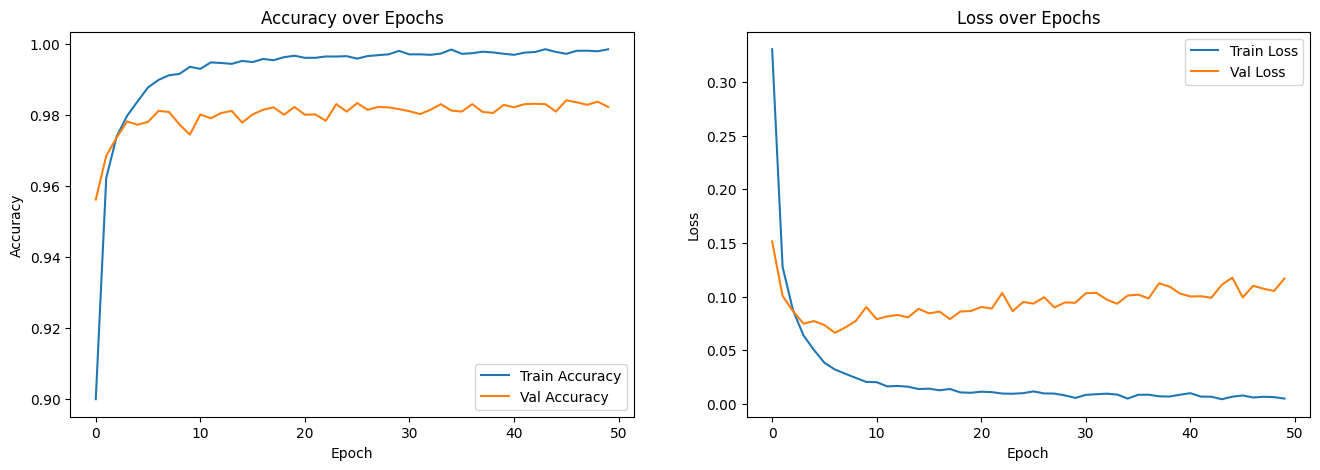

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# ---- Model (same architecture as before) ----
num_classes = y_train.shape[1] if (y_train.ndim == 2 and y_train.shape[1] > 1) else 10
loss_obj    = keras.losses.CategoricalCrossentropy() if (y_train.ndim == 2 and y_train.shape[1] > 1) else keras.losses.SparseCategoricalCrossentropy()
train_acc   = keras.metrics.CategoricalAccuracy() if (y_train.ndim == 2 and y_train.shape[1] > 1) else keras.metrics.SparseCategoricalAccuracy()
val_acc     = keras.metrics.CategoricalAccuracy() if (y_val.ndim == 2 and y_val.shape[1] > 1) else keras.metrics.SparseCategoricalAccuracy()

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),
    layers.Dense(512, activation="relu",
                 kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42)),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu",
                 kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42)),
    layers.Dense(num_classes, activation="softmax",
                 kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42)),
])

optimizer = keras.optimizers.Adam(1e-3)
nr_epochs = 50
batch_size = 128

# ---- Data pipeline (replaces next_batch/iter loops) ----
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val,   y_val)).batch(batch_size)

# ---- TensorBoard writers (replace merged_summary/train_writer/validation_writer) ----
train_writer = tf.summary.create_file_writer("logs/custom/train")
val_writer   = tf.summary.create_file_writer("logs/custom/val")

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss   = loss_obj(y, y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_acc.update_state(y, y_pred)
    return loss

@tf.function
def val_step(x, y):
    y_pred = model(x, training=False)
    v_loss = loss_obj(y, y_pred)
    val_acc.update_state(y, y_pred)
    return v_loss

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(nr_epochs):
    # ======== Training loop (epoch) ========
    train_acc.reset_state()
    epoch_train_loss = 0.0
    batches = 0

    for xb, yb in train_ds:
        loss = train_step(xb, yb)
        epoch_train_loss += loss
        batches += 1

    epoch_train_loss = epoch_train_loss / tf.cast(batches, tf.float32)

    # ======== Validation loop ========
    val_acc.reset_state()
    epoch_val_loss = 0.0
    vbatches = 0

    for xb, yb in val_ds:
        vloss = val_step(xb, yb)
        epoch_val_loss += vloss
        vbatches += 1

    epoch_val_loss = epoch_val_loss / tf.cast(vbatches, tf.float32)

    # ======== Write TensorBoard summaries (per epoch) ========
    with train_writer.as_default():
        tf.summary.scalar("loss", epoch_train_loss, step=epoch)
        tf.summary.scalar("accuracy", train_acc.result(), step=epoch)
    with val_writer.as_default():
        tf.summary.scalar("loss", epoch_val_loss, step=epoch)
        tf.summary.scalar("accuracy", val_acc.result(), step=epoch)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss {epoch_train_loss:.4f} Acc {train_acc.result():.4f} | "
          f"Val Loss {epoch_val_loss:.4f} Acc {val_acc.result():.4f}")

    train_losses.append(float(epoch_train_loss))
    val_losses.append(float(epoch_val_loss))
    train_accs.append(float(train_acc.result()))
    val_accs.append(float(val_acc.result()))

print("Done training!")

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# ---- Plot Loss ----
plt.subplot(1,2,2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

## Make a Prediction

In [20]:
from PIL import Image

zip_path = "data/MNIST.zip"

with zipfile.ZipFile(zip_path) as z:
    with z.open("test_img.png") as f:
        img = Image.open(f)
        img = img.convert("L")   

img

In [22]:
img_array = np.array(img)

# 2. Invert colors if your training data is white text on black background
img_array = np.invert(img_array)

# 3. Normalize like training data (0–1)
img_array = img_array.astype("float32") / 255.0

# 4. Reshape to match model input
test_img = img_array.reshape(1, 28*28) 

# 5. Predict
probs = model.predict(test_img)  # shape (1, 10)
pred = np.argmax(probs, axis=1)

print(f"Prediction for test image is {pred[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction for test image is 2
